In [2]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import math
import time

Custom one hot encoder for MNIST

In [3]:
def encode_output(y):
    encoded_list = []

    # loops through all outputs an encodes them as a 10 length array of zeros and one 1
    for n in y:
        categorical_list = np.zeros(10, dtype = int)
        # sets the value of the nth item in the list to 1
        categorical_list[int(n)] = 1
        encoded_list.append(categorical_list)
    
    return encoded_list

Activation functions for neural network and their derivatives

In [4]:
def sigmoid(input, derivative= False):
    sig = 1 / (1 + np.exp(-input))

    if derivative:
        return sig * (1 - sig)

    return sig

def relu(input, derivative= False):
    if derivative:
        return np.sign(input)
    
    return np.maximum(0, input)

def softmax(input, derivative= False):
    exp = np.exp(input - max(input))
    exp_sum = np.sum(exp, axis=0)
    softmax_result = exp / exp_sum

    if derivative:
        return exp / np.sum(exp, axis=0) * (1 - exp / np.sum(exp, axis=0))

    return softmax_result

Initialises the weights for a neural network for mnsit

In [5]:
def init_neural_network(layer_sizes):
    # input and output are the only layers that are of a fixed size, all others are flexible
    INPUT_SIZE = 784
    OUTPUT_SIZE = 10
    neural_net = {}

    # initialises the first hidden layer
    neural_net['W1'] = layer_gen(INPUT_SIZE, layer_sizes[0])

    # loops through all hidden layer sizes and initialises them in the neural network
    for index, value in enumerate(layer_sizes):
        # sets the hidden layer that connects to the output
        if index == len(layer_sizes) - 1:
            neural_net['W' + str(len(layer_sizes) + 1)] = layer_gen(layer_sizes[-1], OUTPUT_SIZE)
        else:
            neural_net['W' + str(index + 2)] = layer_gen(value, layer_sizes[index + 1])        

    return neural_net

Generates the matrix representation of a transition between 2 layers

In [6]:
def layer_gen(prev_layer, new_layer):
    layer = np.random.randn(new_layer, prev_layer) * np.sqrt(1. / new_layer)

    return layer

Runs a parameterized forward pass which can take an array of activation functions

In [7]:
def forward_pass(params, training_data, activation_functions):
    # gets the input parameters
    params['A0'] = training_data

    # loops forward through the layers until the output is reached
    for index, function in enumerate(activation_functions):
        layer_forward(params, index + 1, function)

    return params['A' + str(len(activation_functions))]

Takes a neural net and an activation function and passes it through a layer

In [8]:
def layer_forward(params, layer_level, func):
    layer_str = str(layer_level)
    params['Z' + layer_str] = np.dot(params['W' + layer_str], params['A' + str(layer_level - 1)])
    params['A' + layer_str] = func(params['Z' + layer_str])

Runs a back pass on the neural net, updating weights to increase the accuracy

In [9]:
def back_pass(params, training_data, output, activation_functions):
    change_w = {}
    layer = len(activation_functions)
    final_layer_func = activation_functions[-1]

    # calculates the error to the final hidden layer, and the changes necessary to it
    error = 2 * (output - training_data) / output.shape[0] * final_layer_func(params['Z' + str(layer)], derivative=True)
    change_w['W' + str(layer)] = np.outer(error, params['A' + str(layer - 1)])

    last_layer = True
    # loops backwards until back at the start of the neural network
    for func in reversed(activation_functions):
        if last_layer:
            last_layer = False
            layer -= 1
        else:
            error = layer_back(params, change_w, error, layer, func)
            layer -= 1

    return change_w

Runs a backpass on a single hidden layer

In [10]:
def layer_back(params, change_w, prev_error, layer_level, func):
    layer_str = str(layer_level)
    error = np.dot(params['W' + str(layer_level + 1)].T, prev_error) * func(params['Z' + layer_str], derivative=True)
    change_w['W' + layer_str] = np.outer(error, params['A' + str(layer_level - 1)])

    return error

Updates the neural network with the changes calculated in the backwards pass

In [12]:
def update_sgd(params, changes_to_w, learning_rate):
    for key in changes_to_w:
        params[key] -= learning_rate * changes_to_w[key]

Calculates the accuracy of the neural net, by doing a forward pass on some sample data

In [13]:
def calculate_accuracy(params, x_vals, y_vals, activation_functions):
    predictions = []

    for x, y in zip(x_vals, y_vals):
        output = forward_pass(params, x, activation_functions)
        # chooses the prediction based on which output has the highest certainty
        prediction = np.argmax(output)
        predictions.append(prediction == np.argmax(y))
    
    return np.mean(predictions)

The training function for the neural network, takes all of the customisable parameters, and inputs them to the network, It will then loop for the requested number of epochs, outputting the time taken, and the accuracy for each epoch

In [14]:
def train(x_training, y_training, x_values, y_values, epochs= 20, learning_rate= 0.001, layer_sizes= [128, 64], activation_functions= [sigmoid, relu, softmax]):
    nn = init_neural_network(layer_sizes)

    times = []
    accuracies = []

    # loops for the given number of epochs
    for iter in range(epochs):
        start_time = time.time()

        # runs training passes for all the training data
        for x, y in zip(x_training, y_training):
            output = forward_pass(nn, x, activation_functions)
            changes_to_w = back_pass(nn, y, output, activation_functions)
            update_sgd(nn, changes_to_w, learning_rate)
        
        # calculates the accuracy of the network
        accuracy = calculate_accuracy(nn, x_values, y_values, activation_functions)
        accuracies.append(accuracy * 100)
        end_time = time.time() - start_time
        times.append(end_time)
        print('Epoch: {0}, Time Spent: {1:.2f}s, Accuracy: {2:.2f}%'.format(iter + 1, end_time, accuracy * 100))
    
    return times, accuracies

Gets the mnist dataset and pre-processes it

In [15]:
x, y = fetch_openml('mnist_784', version=1, return_X_y=True)
x = (x/255).astype('float32')
y = encode_output(y)

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.15, random_state=42)

The following are all tests to find the best activation function, and plotting the results

In [14]:
# SIGMOID TESTS

sigmoid_test_1_times, sigmoid_test_1_accuracies = train(x_train, y_train, x_val, y_val, activation_functions=[sigmoid, sigmoid, sigmoid])
sigmoid_test_2_times, sigmoid_test_2_accuracies = train(x_train, y_train, x_val, y_val, activation_functions=[sigmoid, sigmoid, sigmoid])
sigmoid_test_3_times, sigmoid_test_3_accuracies = train(x_train, y_train, x_val, y_val, activation_functions=[sigmoid, sigmoid, sigmoid])

sigmoid_test_all_times = np.array([sigmoid_test_1_times, sigmoid_test_2_times, sigmoid_test_3_times])
sigmoid_test_avg_times = np.average(sigmoid_test_all_times, axis=0)
sigmoid_test_all_accuracies = np.array([sigmoid_test_1_accuracies, sigmoid_test_2_accuracies, sigmoid_test_3_accuracies])
sigmoid_test_avg_accuracies = np.average(sigmoid_test_all_accuracies, axis=0)

Epoch: 1, Time Spent: 22.42s, Accuracy: 24.98%
Epoch: 2, Time Spent: 21.69s, Accuracy: 25.30%
Epoch: 3, Time Spent: 21.43s, Accuracy: 27.28%
Epoch: 4, Time Spent: 20.88s, Accuracy: 30.01%
Epoch: 5, Time Spent: 21.33s, Accuracy: 33.68%
Epoch: 6, Time Spent: 21.28s, Accuracy: 38.69%
Epoch: 7, Time Spent: 23.02s, Accuracy: 44.34%
Epoch: 8, Time Spent: 22.88s, Accuracy: 49.92%
Epoch: 9, Time Spent: 23.19s, Accuracy: 54.57%
Epoch: 10, Time Spent: 23.13s, Accuracy: 58.65%
Epoch: 11, Time Spent: 22.42s, Accuracy: 62.26%
Epoch: 12, Time Spent: 21.59s, Accuracy: 65.29%
Epoch: 13, Time Spent: 21.53s, Accuracy: 68.23%
Epoch: 14, Time Spent: 22.01s, Accuracy: 70.79%
Epoch: 15, Time Spent: 22.23s, Accuracy: 72.67%
Epoch: 16, Time Spent: 23.81s, Accuracy: 74.09%
Epoch: 17, Time Spent: 23.46s, Accuracy: 75.23%
Epoch: 18, Time Spent: 21.67s, Accuracy: 76.18%
Epoch: 19, Time Spent: 22.33s, Accuracy: 77.19%
Epoch: 20, Time Spent: 23.33s, Accuracy: 78.13%
Epoch: 1, Time Spent: 23.28s, Accuracy: 21.53%
Ep

In [17]:
# RELU TESTS

relu_test_1_times, relu_test_1_accuracies = train(x_train, y_train, x_val, y_val, activation_functions=[relu, relu, relu])
relu_test_2_times, relu_test_2_accuracies = train(x_train, y_train, x_val, y_val, activation_functions=[relu, relu, relu])
relu_test_3_times, relu_test_3_accuracies = train(x_train, y_train, x_val, y_val, activation_functions=[relu, relu, relu])

relu_test_all_times = np.array([relu_test_1_times, relu_test_2_times, relu_test_3_times])
relu_test_avg_times = np.average(relu_test_all_times, axis=0)
relu_test_all_accuracies = np.array([relu_test_1_accuracies, relu_test_2_accuracies, relu_test_3_accuracies])
relu_test_avg_accuracies = np.average(relu_test_all_accuracies, axis=0)

# RELU SIGMOID

relu_sig_1_times, relu_sig_1_accuracies = train(x_train, y_train, x_val, y_val, activation_functions=[relu, relu, sigmoid])
relu_sig_2_times, relu_sig_2_accuracies = train(x_train, y_train, x_val, y_val, activation_functions=[relu, relu, sigmoid])
relu_sig_3_times, relu_sig_3_accuracies = train(x_train, y_train, x_val, y_val, activation_functions=[relu, relu, sigmoid])

relu_sig_all_times = np.array([relu_sig_1_times, relu_sig_2_times, relu_sig_3_times])
relu_sig_avg_times = np.average(relu_sig_all_times, axis=0)
relu_sig_all_accuracies = np.array([relu_sig_1_accuracies, relu_sig_2_accuracies, relu_sig_3_accuracies])
relu_sig_avg_accuracies = np.average(relu_sig_all_accuracies, axis=0)

# RELU SOFTMAX

relu_sof_1_times, relu_sof_1_accuracies = train(x_train, y_train, x_val, y_val, activation_functions=[relu, relu, softmax])
relu_sof_2_times, relu_sof_2_accuracies = train(x_train, y_train, x_val, y_val, activation_functions=[relu, relu, softmax])
relu_sof_3_times, relu_sof_3_accuracies = train(x_train, y_train, x_val, y_val, activation_functions=[relu, relu, softmax])

relu_sof_all_times = np.array([relu_sof_1_times, relu_sof_2_times, relu_sof_3_times])
relu_sof_avg_times = np.average(relu_sof_all_times, axis=0)
relu_sof_all_accuracies = np.array([relu_sof_1_accuracies, relu_sof_2_accuracies, relu_sof_3_accuracies])
relu_sof_avg_accuracies = np.average(relu_sof_all_accuracies, axis=0)

Epoch: 1, Time Spent: 26.05s, Accuracy: 9.86%
Epoch: 2, Time Spent: 27.41s, Accuracy: 9.86%
Epoch: 3, Time Spent: 27.11s, Accuracy: 9.86%
Epoch: 4, Time Spent: 25.73s, Accuracy: 9.86%
Epoch: 5, Time Spent: 26.48s, Accuracy: 9.86%
Epoch: 6, Time Spent: 25.78s, Accuracy: 9.86%
Epoch: 7, Time Spent: 27.03s, Accuracy: 9.86%
Epoch: 8, Time Spent: 26.07s, Accuracy: 9.86%
Epoch: 9, Time Spent: 26.54s, Accuracy: 9.86%
Epoch: 10, Time Spent: 29.03s, Accuracy: 9.86%
Epoch: 11, Time Spent: 29.85s, Accuracy: 9.86%
Epoch: 12, Time Spent: 27.57s, Accuracy: 9.86%
Epoch: 13, Time Spent: 25.76s, Accuracy: 9.86%
Epoch: 14, Time Spent: 28.21s, Accuracy: 9.86%
Epoch: 15, Time Spent: 25.86s, Accuracy: 9.86%
Epoch: 16, Time Spent: 26.47s, Accuracy: 9.86%
Epoch: 17, Time Spent: 26.67s, Accuracy: 9.86%
Epoch: 18, Time Spent: 27.40s, Accuracy: 9.86%
Epoch: 19, Time Spent: 26.45s, Accuracy: 9.86%
Epoch: 20, Time Spent: 27.67s, Accuracy: 9.86%
Epoch: 1, Time Spent: 24.60s, Accuracy: 9.86%
Epoch: 2, Time Spent: 2

In [18]:
# SOFTMAX TESTS

softmax_test_1_times, softmax_test_1_accuracies = train(x_train, y_train, x_val, y_val, activation_functions=[softmax, softmax, softmax])
softmax_test_2_times, softmax_test_2_accuracies = train(x_train, y_train, x_val, y_val, activation_functions=[softmax, softmax, softmax])
softmax_test_3_times, softmax_test_3_accuracies = train(x_train, y_train, x_val, y_val, activation_functions=[softmax, softmax, softmax])

softmax_test_all_times = np.array([softmax_test_1_times, softmax_test_2_times, softmax_test_3_times])
softmax_test_avg_times = np.average(softmax_test_all_times, axis=0)
softmax_test_all_accuracies = np.array([softmax_test_1_accuracies, softmax_test_2_accuracies, softmax_test_3_accuracies])
softmax_test_avg_accuracies = np.average(softmax_test_all_accuracies, axis=0)

# SOFTMAX SIGMOID

softmax_sig_1_times, softmax_sig_1_accuracies = train(x_train, y_train, x_val, y_val, activation_functions=[sigmoid, sigmoid, softmax])
softmax_sig_2_times, softmax_sig_2_accuracies = train(x_train, y_train, x_val, y_val, activation_functions=[sigmoid, sigmoid, softmax])
softmax_sig_3_times, softmax_sig_3_accuracies = train(x_train, y_train, x_val, y_val, activation_functions=[sigmoid, sigmoid, softmax])

softmax_sig_all_times = np.array([softmax_sig_1_times, softmax_sig_2_times, softmax_sig_3_times])
softmax_sig_avg_times = np.average(softmax_sig_all_times, axis=0)
softmax_sig_all_accuracies = np.array([softmax_sig_1_accuracies, softmax_sig_2_accuracies, softmax_sig_3_accuracies])
softmax_sig_avg_accuracies = np.average(softmax_sig_all_accuracies, axis=0)

Epoch: 1, Time Spent: 54.56s, Accuracy: 9.22%
Epoch: 2, Time Spent: 50.01s, Accuracy: 9.22%
Epoch: 3, Time Spent: 44.52s, Accuracy: 9.22%
Epoch: 4, Time Spent: 51.60s, Accuracy: 9.22%
Epoch: 5, Time Spent: 52.66s, Accuracy: 9.22%
Epoch: 6, Time Spent: 53.72s, Accuracy: 9.22%
Epoch: 7, Time Spent: 58.58s, Accuracy: 9.22%
Epoch: 8, Time Spent: 50.26s, Accuracy: 9.22%
Epoch: 9, Time Spent: 45.82s, Accuracy: 9.22%
Epoch: 10, Time Spent: 46.58s, Accuracy: 9.22%
Epoch: 11, Time Spent: 45.57s, Accuracy: 9.22%
Epoch: 12, Time Spent: 47.96s, Accuracy: 9.22%
Epoch: 13, Time Spent: 50.41s, Accuracy: 9.22%
Epoch: 14, Time Spent: 45.53s, Accuracy: 9.22%
Epoch: 15, Time Spent: 58.45s, Accuracy: 9.22%
Epoch: 16, Time Spent: 50.46s, Accuracy: 9.22%
Epoch: 17, Time Spent: 49.65s, Accuracy: 9.22%
Epoch: 18, Time Spent: 48.28s, Accuracy: 9.22%
Epoch: 19, Time Spent: 47.96s, Accuracy: 9.22%
Epoch: 20, Time Spent: 49.46s, Accuracy: 9.22%
Epoch: 1, Time Spent: 47.98s, Accuracy: 10.57%
Epoch: 2, Time Spent: 

In [19]:
# ONE OF ALL TESTS

one_of_each_test_1_times, one_of_each_test_1_accuracies = train(x_train, y_train, x_val, y_val, activation_functions=[sigmoid, relu, softmax])
one_of_each_test_2_times, one_of_each_test_2_accuracies = train(x_train, y_train, x_val, y_val, activation_functions=[sigmoid, relu, softmax])
one_of_each_test_3_times, one_of_each_test_3_accuracies = train(x_train, y_train, x_val, y_val, activation_functions=[sigmoid, relu, softmax])

one_of_each_test_all_times = np.array([one_of_each_test_1_times, one_of_each_test_2_times, one_of_each_test_3_times])
one_of_each_test_avg_times = np.average(one_of_each_test_all_times, axis=0)
one_of_each_test_all_accuracies = np.array([one_of_each_test_1_accuracies, one_of_each_test_2_accuracies, one_of_each_test_3_accuracies])
one_of_each_test_avg_accuracies = np.average(one_of_each_test_all_accuracies, axis=0)

Epoch: 1, Time Spent: 25.44s, Accuracy: 47.23%
Epoch: 2, Time Spent: 25.35s, Accuracy: 59.51%
Epoch: 3, Time Spent: 25.32s, Accuracy: 68.70%
Epoch: 4, Time Spent: 25.25s, Accuracy: 74.76%
Epoch: 5, Time Spent: 25.19s, Accuracy: 77.32%
Epoch: 6, Time Spent: 25.72s, Accuracy: 78.81%
Epoch: 7, Time Spent: 25.44s, Accuracy: 79.41%
Epoch: 8, Time Spent: 25.75s, Accuracy: 79.78%
Epoch: 9, Time Spent: 25.57s, Accuracy: 80.20%
Epoch: 10, Time Spent: 25.62s, Accuracy: 80.53%
Epoch: 11, Time Spent: 25.35s, Accuracy: 80.69%
Epoch: 12, Time Spent: 25.88s, Accuracy: 80.96%
Epoch: 13, Time Spent: 25.51s, Accuracy: 81.11%
Epoch: 14, Time Spent: 25.34s, Accuracy: 81.34%
Epoch: 15, Time Spent: 25.50s, Accuracy: 81.46%
Epoch: 16, Time Spent: 25.24s, Accuracy: 81.57%
Epoch: 17, Time Spent: 25.77s, Accuracy: 81.68%
Epoch: 18, Time Spent: 25.30s, Accuracy: 83.10%
Epoch: 19, Time Spent: 25.86s, Accuracy: 85.16%
Epoch: 20, Time Spent: 25.36s, Accuracy: 86.14%
Epoch: 1, Time Spent: 26.76s, Accuracy: 46.76%
Ep

In [20]:
# LONG RUNNING TESTS

long_run_all_functions_times, long_run_all_functions_accuracies = train(x_train, y_train, x_val, y_val, epochs=100, activation_functions=[sigmoid, relu, softmax])
long_run_sigmoid_times, long_run_sigmoid_accuracies = train(x_train, y_train, x_val, y_val, epochs=100, activation_functions=[sigmoid, sigmoid, sigmoid])
long_run_relu_sig_times, long_run_relu_sig_accuracies = train(x_train, y_train, x_val, y_val, epochs=100, activation_functions=[relu, relu, sigmoid])
long_run_relu_sof_times, long_run_relu_sof_accuracies = train(x_train, y_train, x_val, y_val, epochs=100, activation_functions=[relu, relu, softmax])

Epoch: 1, Time Spent: 25.75s, Accuracy: 44.91%
Epoch: 2, Time Spent: 25.36s, Accuracy: 62.73%
Epoch: 3, Time Spent: 25.71s, Accuracy: 71.25%
Epoch: 4, Time Spent: 25.23s, Accuracy: 39.24%
Epoch: 5, Time Spent: 25.31s, Accuracy: 31.55%
Epoch: 6, Time Spent: 25.17s, Accuracy: 51.27%
Epoch: 7, Time Spent: 25.20s, Accuracy: 48.37%
Epoch: 8, Time Spent: 25.41s, Accuracy: 48.39%
Epoch: 9, Time Spent: 26.11s, Accuracy: 49.11%
Epoch: 10, Time Spent: 24.68s, Accuracy: 57.90%
Epoch: 11, Time Spent: 24.76s, Accuracy: 62.15%
Epoch: 12, Time Spent: 26.31s, Accuracy: 64.72%
Epoch: 13, Time Spent: 25.22s, Accuracy: 65.64%
Epoch: 14, Time Spent: 25.99s, Accuracy: 68.98%
Epoch: 15, Time Spent: 25.49s, Accuracy: 72.46%
Epoch: 16, Time Spent: 26.83s, Accuracy: 74.71%
Epoch: 17, Time Spent: 25.55s, Accuracy: 77.05%
Epoch: 18, Time Spent: 29.02s, Accuracy: 78.19%
Epoch: 19, Time Spent: 25.22s, Accuracy: 79.87%
Epoch: 20, Time Spent: 24.96s, Accuracy: 80.96%
Epoch: 21, Time Spent: 24.98s, Accuracy: 81.42%
E

In [42]:
# LAYER TESTS

# ideas:
# run with most stable of long runners
# 20 epochs
# layer sizes by evenly splitting input/output by layers

Utility function to simplify running many tests

In [22]:
def plot_performance(axes, title, y_label, results, colours, labels=['test 1', 'test 2', 'test 3', 'average'], dashed=True):
    axes.set_title(title)
    axes.set_ylabel(y_label)

    if(dashed):
        axes.plot(results[0], color=colours[0], label=labels[0], linestyle='dashed')
        axes.plot(results[1], color=colours[1], label=labels[1], linestyle='dashed')
        axes.plot(results[2], color=colours[2], label=labels[2], linestyle='dashed')
    else:
        axes.plot(results[0], color=colours[0], label=labels[0])
        axes.plot(results[1], color=colours[1], label=labels[1])
        axes.plot(results[2], color=colours[2], label=labels[2])
    axes.plot(results[3], color=colours[3], label=labels[3])
    axes.legend(bbox_to_anchor=(1.005, 1))

Plotting of all the results

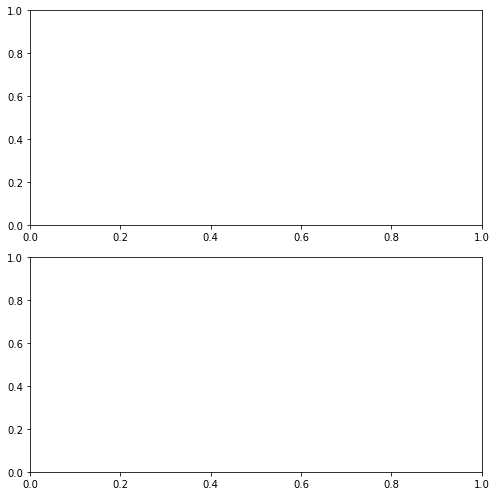

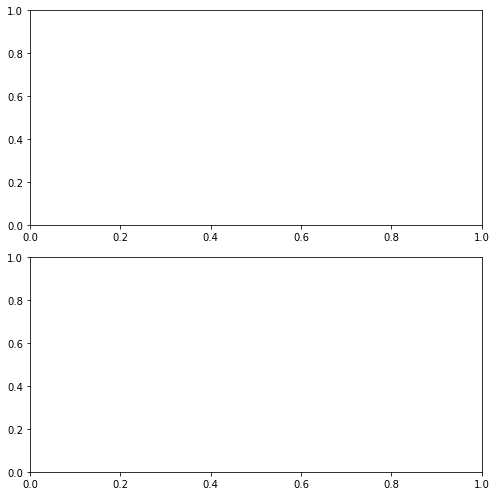

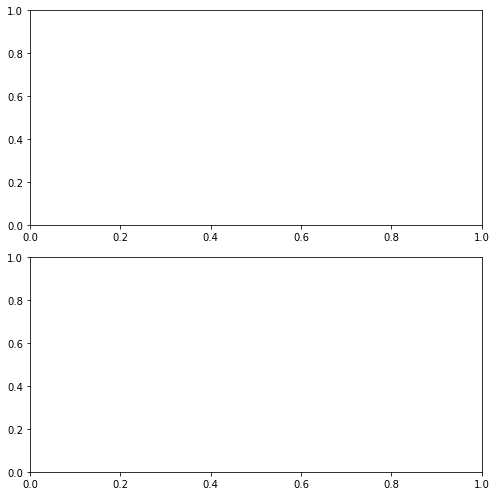

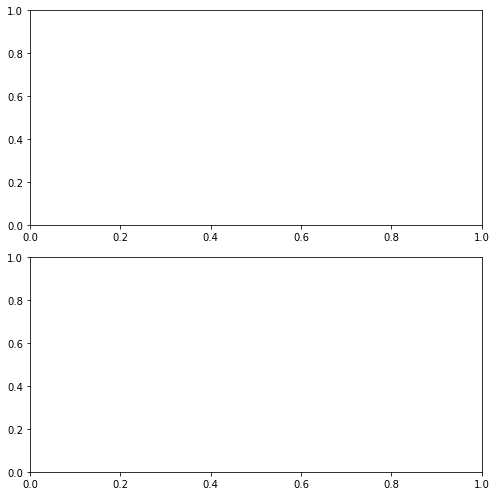

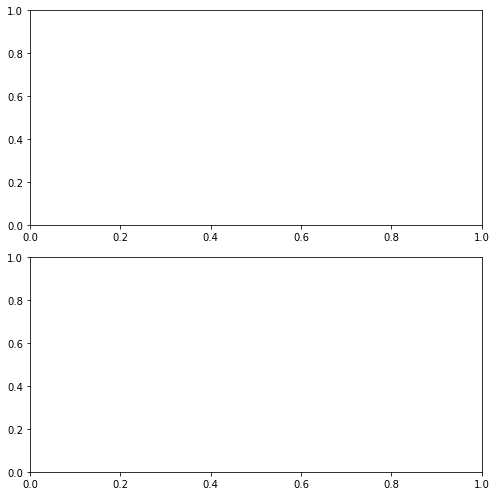

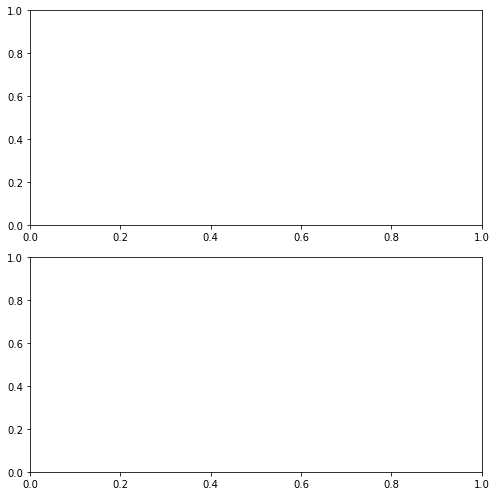

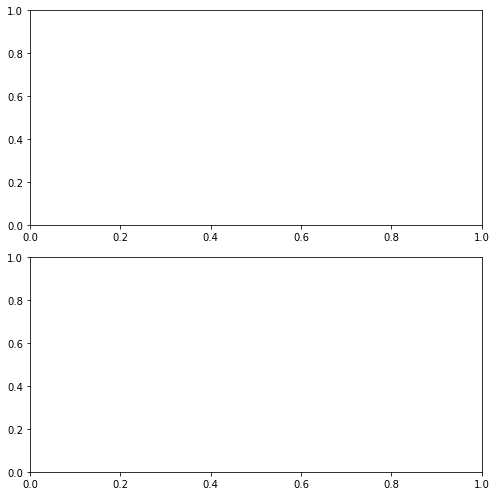

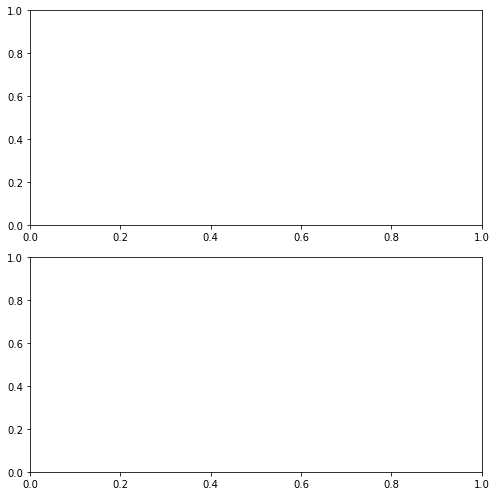

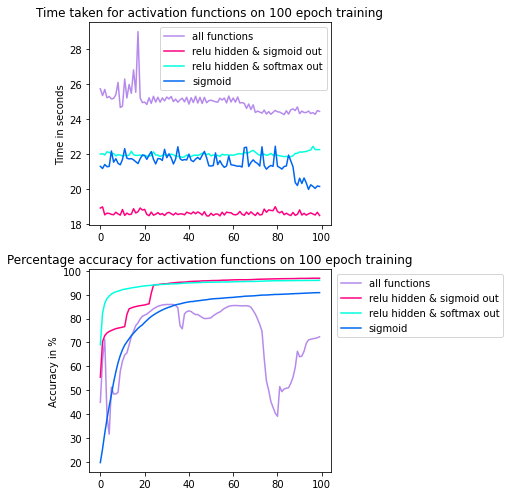

In [25]:
FIG_SIZE = (7, 7)

fig1, (ax1, ax2) = plt.subplots(2)
fig1.set_size_inches(FIG_SIZE)
fig1.set_tight_layout(True)

fig2, (ax3, ax4) = plt.subplots(2)
fig2.set_size_inches(FIG_SIZE)
fig2.set_tight_layout(True)

fig3, (ax5, ax6) = plt.subplots(2)
fig3.set_size_inches(FIG_SIZE)
fig3.set_tight_layout(True)

fig4, (ax7, ax8) = plt.subplots(2)
fig4.set_size_inches(FIG_SIZE)
fig4.set_tight_layout(True)

fig5, (ax9, ax10) = plt.subplots(2)
fig5.set_size_inches(FIG_SIZE)
fig5.set_tight_layout(True)

fig6, (ax11, ax12) = plt.subplots(2)
fig6.set_size_inches(FIG_SIZE)
fig6.set_tight_layout(True)

fig7, (ax13, ax14) = plt.subplots(2)
fig7.set_size_inches(FIG_SIZE)
fig7.set_tight_layout(True)

fig8, (ax15, ax16) = plt.subplots(2)
fig8.set_size_inches(FIG_SIZE)
fig8.set_tight_layout(True)

fig9, (ax17, ax18) = plt.subplots(2)
fig9.set_size_inches(FIG_SIZE)
fig9.set_tight_layout(True)

#######################################
# Sigmoid performance
#######################################

# plot_performance(ax1, 'Time taken for only sigmoid activation function', 'Time in seconds', [sigmoid_test_1_times, sigmoid_test_2_times, sigmoid_test_3_times, sigmoid_test_avg_times], ['#00f2ec', '#0096f2', '#0643A5', '#0066f2'])

# plot_performance(ax2, 'Percentage accuracy for only sigmoid activation function', 'Accuracy in %', [sigmoid_test_1_accuracies, sigmoid_test_2_accuracies, sigmoid_test_3_accuracies, sigmoid_test_avg_accuracies], ['#00f2ec', '#0096f2', '#0643A5', '#0066f2'])

# #######################################
# # Relu performance
# #######################################

# plot_performance(ax3, 'Time taken for only relu activation function', 'Time in seconds', [relu_test_1_times, relu_test_2_times, relu_test_3_times, relu_test_avg_times], ['#ff9a00', '#ff6700', '#a60202', '#ff0000'])

# plot_performance(ax4, 'Percentage accuracy for only relu activation function', 'Accuracy in %', [relu_test_1_accuracies, relu_test_2_accuracies, relu_test_3_accuracies, relu_test_avg_accuracies], ['#ff9a00', '#ff6700', '#a60202', '#ff0000'])

# #######################################
# # Softmax performance
# #######################################

# plot_performance(ax5, 'Time taken for only softmax activation function', 'Time in seconds', [softmax_test_1_times, softmax_test_2_times, softmax_test_3_times, softmax_test_avg_times], ['#89ff01', '#349404', '#024b30', '#037d50'])

# plot_performance(ax6, 'Percentage accuracy for only softmax activation function', 'Accuracy in %', [softmax_test_1_accuracies, softmax_test_2_accuracies, softmax_test_3_accuracies, softmax_test_avg_accuracies], ['#89ff01', '#349404', '#024b30', '#037d50'])

# #######################################
# # All performance
# #######################################

# plot_performance(ax7, 'Time taken for sigmoid, relu and softmax functions', 'Time in seconds', [one_of_each_test_1_times, one_of_each_test_2_times, one_of_each_test_3_times, one_of_each_test_avg_times], ['#ff5555', '#ff00e7', '#7a48b0', '#b68aed'])

# plot_performance(ax8, 'Percentage accuracy for sigmoid, relu and softmax functions', 'Accuracy in %', [one_of_each_test_1_accuracies, one_of_each_test_2_accuracies, one_of_each_test_3_accuracies, one_of_each_test_avg_accuracies], ['#ff5555', '#ff00e7', '#7a48b0', '#b68aed'])

# #######################################
# # Relu sigmoid performance
# #######################################

# plot_performance(ax9, 'Time taken for relu activation function with sigmoid output', 'Time in seconds', [relu_sig_1_times, relu_sig_2_times, relu_sig_3_times, relu_sig_avg_times], ['#ff9a00', '#ff6700', '#a60202', '#ff0000'])

# plot_performance(ax10, 'Percentage accuracy for relu activation function with sigmoid output', 'Accuracy in %', [relu_sig_1_accuracies, relu_sig_2_accuracies, relu_sig_3_accuracies, relu_sig_avg_accuracies], ['#ff9a00', '#ff6700', '#a60202', '#ff0000'])

# #######################################
# # Relu softmax performance
# #######################################

# plot_performance(ax11, 'Time taken for relu activation function with softmax output', 'Time in seconds', [relu_sof_1_times, relu_sof_2_times, relu_sof_3_times, relu_sof_avg_times], ['#ff9a00', '#ff6700', '#a60202', '#ff0000'])

# plot_performance(ax12, 'Percentage accuracy for relu activation function with softmax output', 'Accuracy in %', [relu_sof_1_accuracies, relu_sof_2_accuracies, relu_sof_3_accuracies, relu_sof_avg_accuracies], ['#ff9a00', '#ff6700', '#a60202', '#ff0000'])

# #######################################
# # Softmax sigmoid performance
# #######################################

# plot_performance(ax13, 'Time taken for softmax output with sigmoid hidden layers', 'Time in seconds', [softmax_sig_1_times, softmax_sig_2_times, softmax_sig_3_times, softmax_sig_avg_times], ['#89ff01', '#349404', '#024b30', '#037d50'])

# plot_performance(ax14, 'Percentage accuracy for softmax output with sigmoid hidden layers', 'Accuracy in %', [softmax_sig_1_accuracies, softmax_sig_2_accuracies, softmax_sig_3_accuracies, softmax_sig_avg_accuracies], ['#89ff01', '#349404', '#024b30', '#037d50'])

# #######################################
# # Performance comparrison
# #######################################

# plot_performance(ax15, 'Time taken for various activation functions', 'Time in seconds', [sigmoid_test_avg_times, relu_test_avg_times, softmax_test_avg_times, one_of_each_test_avg_times], ['#0066f2', '#ff0000', '#037d50', '#b68aed'], ['sigmoid', 'relu', 'softmax', 'all functions'], False)

# ax15.plot(relu_sig_avg_times, color='#ff0081', label='relu hidden & sigmoid out')
# ax15.plot(relu_sof_avg_times, color='#00ffdf', label='relu hidden & softmax out')
# ax15.plot(softmax_sig_avg_times, color='#46ba00', label='sigmoid hidden & softmax out')
# ax15.legend(bbox_to_anchor=(1.005, 1))

# plot_performance(ax16, 'Percentage accuracy for various activation functions', 'Accuracy in %', [sigmoid_test_avg_accuracies, relu_test_avg_accuracies, softmax_test_avg_accuracies, one_of_each_test_avg_accuracies], ['#0066f2', '#ff0000', '#037d50', '#b68aed'], ['sigmoid', 'relu', 'softmax', 'all functions'], False)

# ax16.plot(relu_sig_avg_accuracies, color='#ff0081', label='relu hidden & sigmoid out')
# ax16.plot(relu_sof_avg_accuracies, color='#00ffdf', label='relu hidden & softmax out')
# ax16.plot(softmax_sig_avg_accuracies, color='#46ba00', label='sigmoid hidden & softmax out')
# ax16.legend(bbox_to_anchor=(1.005, 1))

#######################################
# Long run performance comparrioson
#######################################

plot_performance(ax17, 'Time taken for activation functions on 100 epoch training', 'Time in seconds', [long_run_all_functions_times, long_run_relu_sig_times, long_run_relu_sof_times, long_run_sigmoid_times], ['#b68aed', '#ff0081', '#00ffdf', '#0066f2'], ['all functions', 'relu hidden & sigmoid out', 'relu hidden & softmax out', 'sigmoid'], False)

plot_performance(ax18, 'Percentage accuracy for activation functions on 100 epoch training', 'Accuracy in %', [long_run_all_functions_accuracies, long_run_relu_sig_accuracies, long_run_relu_sof_accuracies, long_run_sigmoid_accuracies], ['#b68aed', '#ff0081', '#00ffdf', '#0066f2'], ['all functions', 'relu hidden & sigmoid out', 'relu hidden & softmax out', 'sigmoid'], False)

plt.show()

https://mlfromscratch.com/neural-network-tutorial/#/